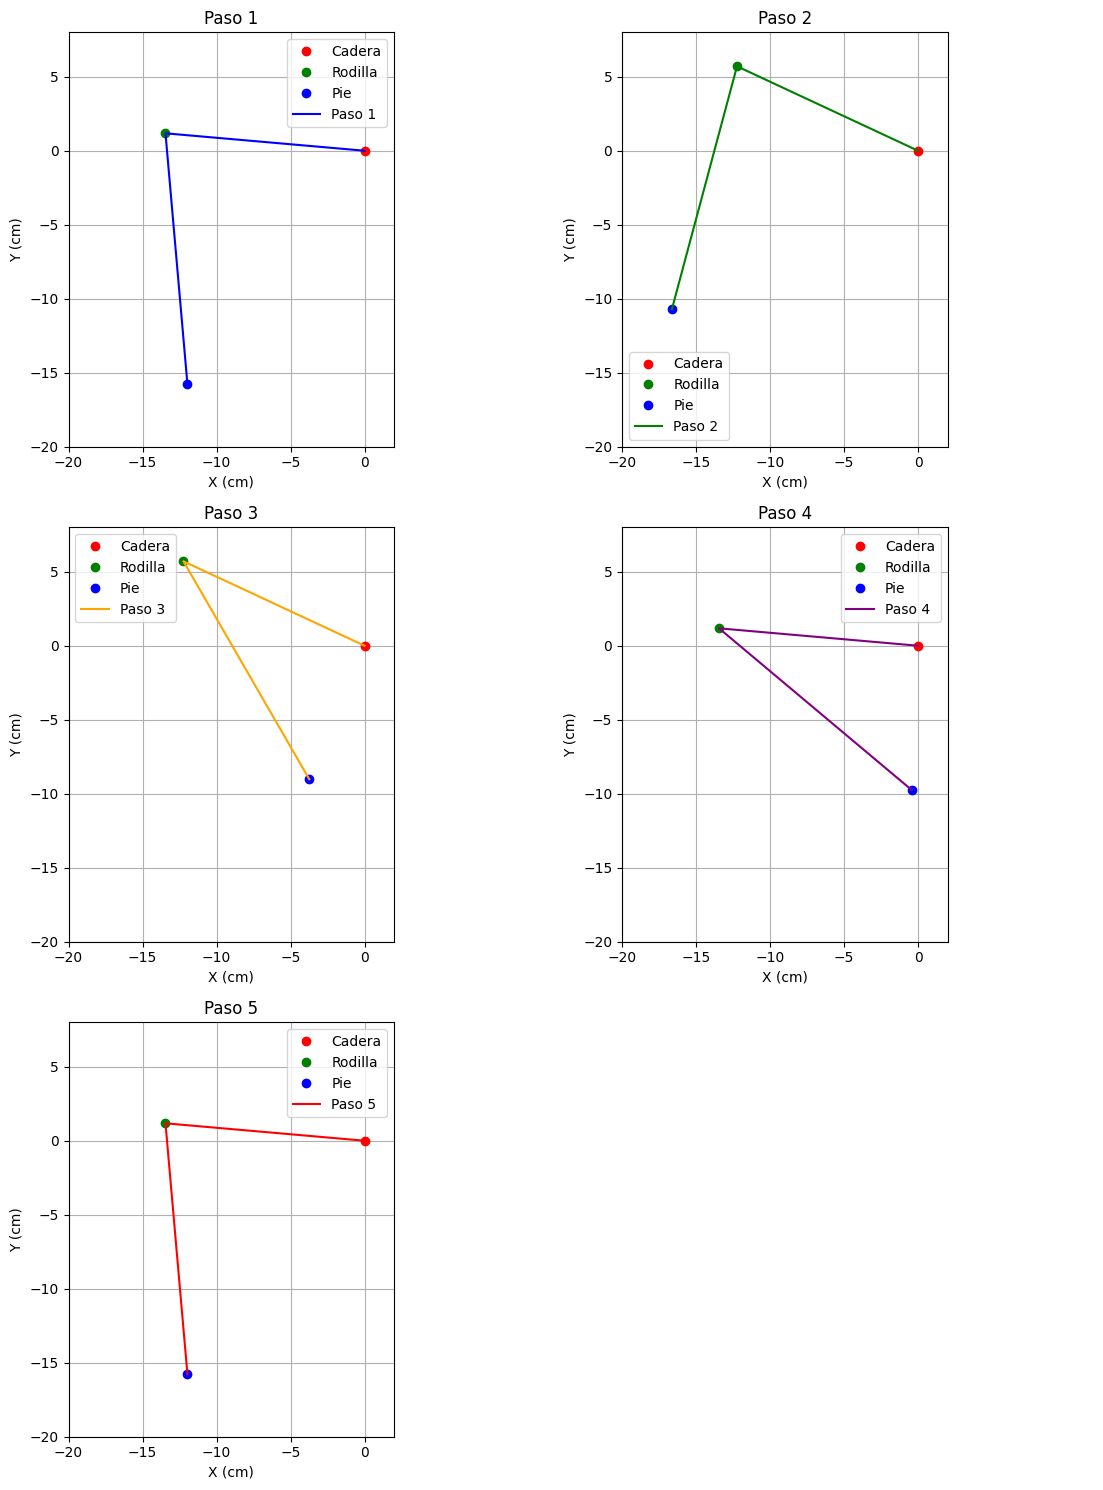

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Longitudes de los eslabones
l1 = 13.5  # longitud de la cadera a la rodilla (cm)
l2 = 17  # longitud de la rodilla al pie (cm)

# Ángulos de las articulaciones (en grados) para los cinco pasos
thetas = [
    (175, 100),  # Paso 1
    (155, 100),   # Paso 2
    (155, 145),   # Paso 3
    (175, 145),  # Paso 4
    (175, 100)   # Paso 5 (volver al paso inicial)
]

# Colores para los diferentes pasos
colors = ['blue', 'green', 'orange', 'purple', 'red']

# Crear la figura y los ejes para los cinco subgráficos
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
axs = axs.flatten()  # Aplanar la matriz de ejes para facilitar la iteración

# Iterar sobre cada paso y visualizar la posición del pie en cada paso
for i, (theta1, theta2) in enumerate(thetas, start=1):
    # Calcular las coordenadas del pie (posición final)
    x_foot = l1 * np.cos(np.radians(theta1)) + l2 * np.cos(np.radians(theta1 + theta2))
    y_foot = l1 * np.sin(np.radians(theta1)) + l2 * np.sin(np.radians(theta1 + theta2))
    
    # Visualizar la posición del pie en el subgráfico correspondiente
    ax = axs[i-1]
    ax.plot(0, 0, 'ro', label='Cadera')
    ax.plot(l1 * np.cos(np.radians(theta1)), l1 * np.sin(np.radians(theta1)), 'go', label='Rodilla')
    ax.plot(x_foot, y_foot, 'bo', label='Pie')
    ax.plot([0, l1 * np.cos(np.radians(theta1)), x_foot], [0, l1 * np.sin(np.radians(theta1)), y_foot], 
            color=colors[i-1], label=f'Paso {i}')
    
    # Configurar el subgráfico
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    ax.set_title(f'Paso {i}')
    ax.grid(True)
    ax.set_xlim(-20, 2)
    ax.set_ylim(-20, 8)
    ax.set_aspect('equal', adjustable='box')
    ax.legend()

# Añadir un espacio vacío para el último subgráfico que no se usa
axs[5].axis('off')

plt.tight_layout()
plt.show()


In [45]:
calibrations = {}

DERECHA_SUPERIOR = 0
DERECHA_INFERIOR = 1
IZQUIERDA_SUPERIOR = 2
IZQUIERDA_INFERIOR = 3

In [68]:
def calibrate_servo(servo_name, joint_angle_ref, servo_angle_ref):
    """
    Calibrates a servo by storing the reference joint angle and servo angle.

    Parameters:
    - servo_name (str): The name of the servo.
    - joint_angle_ref (float): The reference joint angle for calibration.
    - servo_angle_ref (float): The reference servo angle for calibration.

    Returns:
    None
    """
    calibrations[servo_name] = {
        'joint_angle_ref': joint_angle_ref,
        'servo_angle_ref': servo_angle_ref,
    }

# Función de mapeo de ángulos
def map_angle_to_servo(servo_name, joint_angle):
    """
    Maps the joint angle to the corresponding servo angle based on the servo name.

    Args:
        servo_name (str): The name of the servo.
        joint_angle (float): The joint angle to be mapped.

    Returns:
        float: The mapped servo angle if the servo name is valid and the servo angle is within the range [0, 180].
        None: If the servo name is invalid or the mapped servo angle is outside the range [0, 180].
    """
    calib = calibrations[servo_name]
    
    if DERECHA_SUPERIOR == servo_name:
        servo_angle = (calib['joint_angle_ref'] - joint_angle) + calib['servo_angle_ref'] 
    elif DERECHA_INFERIOR == servo_name:
        servo_angle = (calib['joint_angle_ref'] - joint_angle) + calib['servo_angle_ref'] 
    elif IZQUIERDA_SUPERIOR == servo_name:
        servo_angle = ( joint_angle - calib['joint_angle_ref']) + calib['servo_angle_ref'] 
    elif IZQUIERDA_INFERIOR == servo_name:
        servo_angle = ( joint_angle - calib['joint_angle_ref']) + calib['servo_angle_ref'] 
    else: return None
    
    if servo_angle < 0 or servo_angle > 180:
        return None
    return servo_angle  # Asegurar que el ángulo está dentro del rango [0, 180]


In [70]:

# Calibración proporcionada por el usuario
calibrate_servo(IZQUIERDA_SUPERIOR, 185, 30)  # Calibración del servo 1: (185 en esquema) => 150 grados en el servo
calibrate_servo(IZQUIERDA_INFERIOR, 100, 135)   # Calibración del servo 2: (100 en esquema) => 130 grados en el servo
calibrate_servo(DERECHA_SUPERIOR, 185, 150)  # Calibración del servo 1: (185 en esquema) => 150 grados en el servo
calibrate_servo(DERECHA_INFERIOR, 100, 45)   # Calibración del servo 2: (100 en esquema) => 45 grados en el servo


# Los ángulos de las articulaciones para los cinco pasos
joint_angles = [
    (175, 100),  # Paso 1
    (155, 100),   # Paso 2
    (155, 145),   # Paso 3
    (175, 145),  # Paso 4
    (175, 100),   # Paso 5 (volver al paso inicial)
]

servo_angles_izquierda = []
for joint1, joint2 in joint_angles:
    servo1 = map_angle_to_servo(IZQUIERDA_SUPERIOR, joint1)
    servo2 = map_angle_to_servo(IZQUIERDA_INFERIOR, joint2)
    if (servo1 == None or servo2 == None):
        continue
    servo_angles_izquierda.append((servo1, servo2))


servo_angles_derecha =[]
for joint1, joint2 in joint_angles:
    servo1 = map_angle_to_servo(DERECHA_SUPERIOR, joint1)
    servo2 = map_angle_to_servo(DERECHA_INFERIOR, joint2)
    if (servo1 == None or servo2 == None):
        continue
    servo_angles_derecha.append((servo1, servo2))

for i, (servo1, servo2) in enumerate(servo_angles_derecha, start=1):
    print(f'Paso {i}: Servo 1: {servo1:.2f} grados, Servo 2: {servo2:.2f} grados')

print("------------------------------------------------------------------")

for i, (servo1, servo2) in enumerate(servo_angles_izquierda, start=1):
    print(f'Paso {i}: Servo 1: {servo1:.2f} grados, Servo 2: {servo2:.2f} grados')

Paso 1: Servo 1: 160.00 grados, Servo 2: 45.00 grados
Paso 2: Servo 1: 180.00 grados, Servo 2: 45.00 grados
Paso 3: Servo 1: 180.00 grados, Servo 2: 0.00 grados
Paso 4: Servo 1: 160.00 grados, Servo 2: 0.00 grados
Paso 5: Servo 1: 160.00 grados, Servo 2: 45.00 grados
------------------------------------------------------------------
Paso 1: Servo 1: 20.00 grados, Servo 2: 135.00 grados
Paso 2: Servo 1: 0.00 grados, Servo 2: 135.00 grados
Paso 3: Servo 1: 0.00 grados, Servo 2: 180.00 grados
Paso 4: Servo 1: 20.00 grados, Servo 2: 180.00 grados
Paso 5: Servo 1: 20.00 grados, Servo 2: 135.00 grados


In [56]:
def cinemática_directa(theta1, theta2):
    """
    Calcula las coordenadas de la rodilla y del pie dados los ángulos de las articulaciones.
    """
    x_rodilla = l1 * np.cos(np.radians(theta1))
    y_rodilla = l1 * np.sin(np.radians(theta1))
    
    x_pie = x_rodilla + l2 * np.cos(np.radians(theta1 + theta2))
    y_pie = y_rodilla + l2 * np.sin(np.radians(theta1 + theta2))
    
    return (x_rodilla, y_rodilla), (x_pie, y_pie)

def cinemática_inversa(x_pie, y_pie, y_hip_new):
    """
    Calcula los ángulos de la cadera y la rodilla para una posición dada del pie y una nueva altura de la cadera.
    """
    d = np.sqrt(x_pie**2 + (y_pie - y_hip_new)**2)
    alpha = np.arctan2(y_pie - y_hip_new, x_pie)
    beta = np.arccos((l1**2 + d**2 - l2**2) / (2 * l1 * d))
    
    theta1 = np.degrees(alpha - beta)
    theta2 = np.degrees(np.arccos((l1**2 + l2**2 - d**2) / (2 * l1 * l2))) - 180
    
    
    return theta1, theta2


----------------------------------------------------
160.00000000000003
45.000000000000014
----------------------------------------------------
----------------------------------------------------
162.15387895871518
43.02785016852526
----------------------------------------------------
----------------------------------------------------
164.3240062191149
41.105496422421965
----------------------------------------------------
----------------------------------------------------
166.5128334923803
39.2319104945466
----------------------------------------------------
----------------------------------------------------
168.72269145167428
37.4063430665819
----------------------------------------------------
----------------------------------------------------
170.95578639819547
35.62830659260436
----------------------------------------------------
----------------------------------------------------
173.21419162163838
33.8975618221304
----------------------------------------------------
--

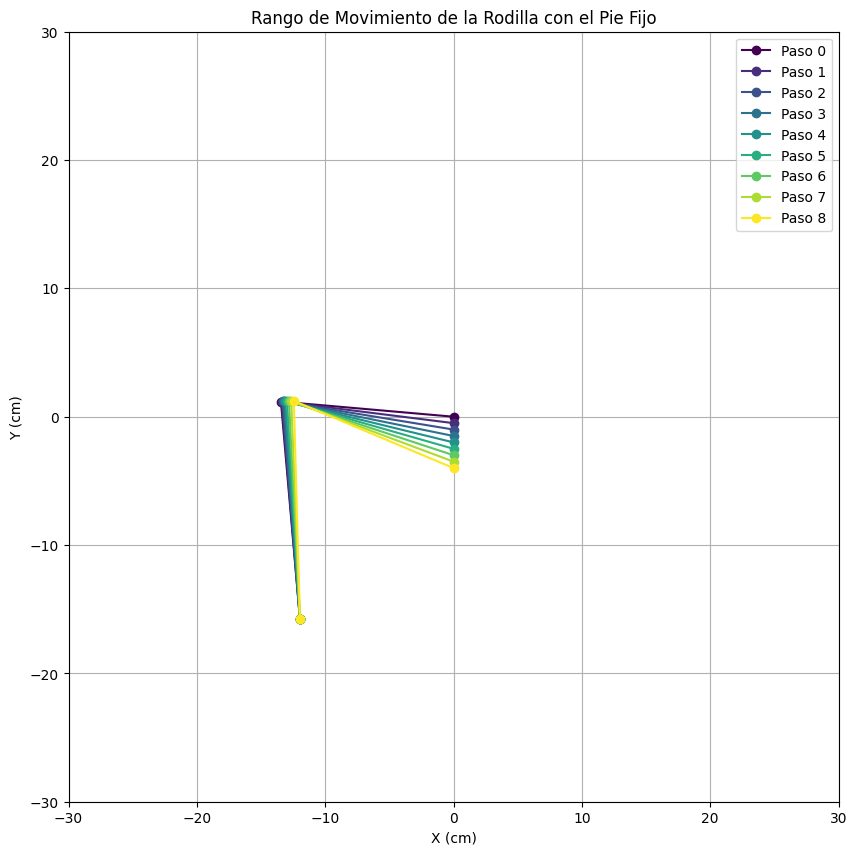

In [74]:

theta1_inicial = 175
theta2_inicial = 100

desplazamiento_vertical = -0.5 # bajar 1 cm

pasos = 8


_, (x_pie, y_pie) = cinemática_directa(theta1_inicial, theta2_inicial)
    
fig, ax = plt.subplots(figsize=(10, 10))
    
    # Colores para los diferentes pasos
colors = plt.cm.viridis(np.linspace(0, 1, pasos+1))
    
    # Visualizar el rango de movimiento de la rodilla para cada posición de la cadera
for i in range(pasos + 1):
    y_hip_new = i * desplazamiento_vertical
        
    # Calcular los nuevos ángulos para mantener la posición del pie constante
    theta1_new, theta2_new = cinemática_inversa(x_pie, y_pie, y_hip_new)
    theta2_new = np.abs(theta2_new)
    
    if (theta1_new < 0):
        theta1_new = theta1_new + 360
    
    print("----------------------------------------------------")
    print(map_angle_to_servo(DERECHA_SUPERIOR, theta1_new))
    print(map_angle_to_servo(DERECHA_INFERIOR, theta2_new))
    print("----------------------------------------------------")
    (rodilla_x, rodilla_y), _ = cinemática_directa(theta1_new, theta2_new)
        
        # Visualizar la posición ajustada
    ax.plot([0, rodilla_x, x_pie], [y_hip_new, rodilla_y + y_hip_new, y_pie], 'o-', color=colors[i], label=f'Paso {i}')
    
    # Configurar el gráfico
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_title('Rango de Movimiento de la Rodilla con el Pie Fijo')
ax.grid(True)
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_aspect('equal', adjustable='box')
ax.legend()
    
plt.show()




In [79]:
import sympy as sp

# Definir los símbolos
theta1, theta2 = sp.symbols('theta1 theta2')
l1, l2 = sp.symbols('l1 l2')

# Matriz de transformación desde la cadera hasta la rodilla
T1 = sp.Matrix([
    [sp.cos(theta1), -sp.sin(theta1), l1 * sp.cos(theta1)],
    [sp.sin(theta1), sp.cos(theta1), l1 * sp.sin(theta1)],
    [0, 0, 1]
])

# Matriz de transformación desde la rodilla hasta el pie
T2 = sp.Matrix([
    [sp.cos(theta2), -sp.sin(theta2), l2 * sp.cos(theta2)],
    [sp.sin(theta2), sp.cos(theta2), l2 * sp.sin(theta2)],
    [0, 0, 1]
])

# Matriz de transformación completa desde la cadera hasta el pie
T = T1 * T2

# Simplificar la matriz de transformación
T = sp.simplify(T)
T

Matrix([
[cos(theta1 + theta2), -sin(theta1 + theta2), l1*cos(theta1) + l2*cos(theta1 + theta2)],
[sin(theta1 + theta2),  cos(theta1 + theta2), l1*sin(theta1) + l2*sin(theta1 + theta2)],
[                   0,                     0,                                        1]])

# Geometría y Cinemática de las Patas de un Robot

## Geometría de las Patas del Robot

Consideremos un robot con una pata que tiene dos articulaciones:
1. **Cadera** (`theta1`): Une el torso del robot a la parte superior de la pierna.
2. **Rodilla** (`theta2`): Une la parte superior de la pierna a la parte inferior.

Las longitudes de los eslabones son:
- \( l1 \): Longitud desde la cadera hasta la rodilla.
- \( l2 \): Longitud desde la rodilla hasta el pie.

## Cinemática Directa

La matriz de transformación homogénea para una rotación y una traslación en 2D se puede representar como:



\begin{equation}
\left[
\begin{matrix}
cos(\theta) & -\sin(\theta) & d_x \\
sin(\theta) & \cos(\theta) & d_y \\
0 & 0 & 1
\end{matrix}
\right]
\end{equation}

Para nuestro robot, necesitamos dos matrices de transformación:
1. Desde la cadera hasta la rodilla.
2. Desde la rodilla hasta el pie.

## Matrices de Transformación

Para la cadera a la rodilla:

\begin{equation}
\left[
\begin{matrix}
cos(\theta_1) & -\sin(\theta_1) & l1 \cos(\theta_1) \\
sin(\theta_1) & \cos(\theta_1) & l1 \sin(\theta_1) \\
0 & 0 & 1
\end{matrix}
\right]
\end{equation}

Para la rodilla al pie:

\begin{equation}
\left[
\begin{matrix}
cos(\theta_2) & -\sin(\theta_2) & l2 \cos(\theta_2) \\
sin(\theta_2) & \cos(\theta_2) & l2 \sin(\theta_2) \\
0 & 0 & 1
\end{matrix}
\right]
\end{equation}


La posición final del pie se obtiene multiplicando estas matrices.

\begin{equation}
\left[
\begin{matrix}
\cos{\left(\theta_{1} + \theta_{2} \right)} & - \sin{\left(\theta_{1} + \theta_{2} \right)} & l_{1} \cos{\left(\theta_{1} \right)} + l_{2} \cos{\left(\theta_{1} + \theta_{2} \right)} \\
\sin{\left(\theta_{1} + \theta_{2} \right)} & \cos{\left(\theta_{1} + \theta_{2} \right)} & l_{1} \sin{\left(\theta_{1} \right)} + l_{2} \sin{\left(\theta_{1} + \theta_{2} \right)} \\
0 & 0 & 1
\end{matrix}
\right]
\end{equation}

